# Question Answering with [WangchanBERTa](https://colab.research.google.com/drive/1Kbk6sBspZLwcnOE61adAQo30xxqOQ9ko#scrollTo=CbEzo1R2vp_H)

This notebook is adapted from [HuggingFace example on QA](https://huggingface.co/transformers/examples.html) for WangchanBERTa. We have modified text processing functions and metrics to suit Thai language.

## Installs and Imports

In [1]:
# !pip install -Uqq datasets pythainlp==2.2.4 transformers==4.4.0

In [2]:
%load_ext autoreload
%autoreload 2

import pythainlp, transformers
pythainlp.__version__, transformers.__version__ #fix pythainlp to stabilize word tokenization for metrics

('2.2.4', '4.4.0')

In [3]:
import collections
import logging
import pprint
import re
from tqdm.auto import tqdm

import numpy as np
import torch

#datasets
from datasets import (
    load_dataset, 
    load_metric, 
    concatenate_datasets,
    load_from_disk,
)

#transformers
from transformers import (
    AutoConfig,
    AutoTokenizer,
    AutoModelForQuestionAnswering,
    TrainingArguments,
    Trainer,
    default_data_collator,
)

#thai2transformers
import thai2transformers
from thai2transformers.metrics import (
    squad_newmm_metric,
    question_answering_metrics,
)
from thai2transformers.preprocess import (
    prepare_qa_train_features
)
from thai2transformers.tokenizers import (
    ThaiRobertaTokenizer,
    ThaiWordsNewmmTokenizer,
    ThaiWordsSyllableTokenizer,
    FakeSefrCutTokenizer,
    SEFR_SPLIT_TOKEN
)

## Choose Pretrained Models

In [4]:
model_names = [
    'wangchanberta-base-att-spm-uncased',
    'xlm-roberta-base',
    'bert-base-multilingual-cased',
    'wangchanberta-base-wiki-newmm',
    'wangchanberta-base-wiki-ssg',
    'wangchanberta-base-wiki-sefr',
    'wangchanberta-base-wiki-spm',
]

tokenizers = {
    'wangchanberta-base-att-spm-uncased': AutoTokenizer,
    'xlm-roberta-base': AutoTokenizer,
    'bert-base-multilingual-cased': AutoTokenizer,
    'wangchanberta-base-wiki-newmm': ThaiWordsNewmmTokenizer,
    'wangchanberta-base-wiki-ssg': ThaiWordsSyllableTokenizer,
    'wangchanberta-base-wiki-sefr': FakeSefrCutTokenizer,
    'wangchanberta-base-wiki-spm': ThaiRobertaTokenizer,
}
public_models = ['xlm-roberta-base', 'bert-base-multilingual-cased'] 
#@title Choose Pretrained Model
model_name = "wangchanberta-base-att-spm-uncased" #@param ["wangchanberta-base-att-spm-uncased", "xlm-roberta-base", "bert-base-multilingual-cased", "wangchanberta-base-wiki-newmm", "wangchanberta-base-wiki-syllable", "wangchanberta-base-wiki-sefr", "wangchanberta-base-wiki-spm"]

#create tokenizer
tokenizer = tokenizers[model_name].from_pretrained(
                f'airesearch/{model_name}' if model_name not in public_models else f'{model_name}',
                revision='main',
                model_max_length=416,)

## Load datasets

In [5]:
#parameterizing columns
CONTEXT_COL = 'context'
QUESTION_COL = 'question'
ANSWERS_COL = 'answers'
TEXT_COL = 'text'
START_COL = 'answer_start'
END_COL = 'answer_end'
QUESTION_ID_COL = 'question_id'

### `iapp_wiki_qa_squad` and `thaiqa_squad`

Question answering datasets in Thai are relatively small (`squad` has 87,599 examples in training set whereas the numbers are 5,761 and 4,000 for `iapp_wiki_qa_squad` and `thaiqa_squad` respectively). Therefore, we will merge `iapp_wiki_qa_squad` with `thaiqa_squad`. Since we are using train and valiation sets of `iapp_wiki_qa_squad`, we will make sure that there are no overlapping contexts between those datasets and the training set of `thaiqa_squad` that we are merging with the training set of `iapp_wiki_qa_squad`.

In [6]:
# #make thaiqa looks like iapp
# def convert_to_iapp(example):
#     extra_tag = re.match('<doc.*>', example['context'][:-7]).group(0)
#     example['answers'] = {
#         'text': example['answers']['answer'],
#         'answer_start': [np.int32(example['answers']['answer_begin_position'][0] - len(extra_tag))],
#         'answer_end': [np.int32(example['answers']['answer_end_position'][0] - len(extra_tag))],
#     }
#     example['context'] = example['context'][len(extra_tag):-7]
#     example['article_id'] = str(example['article_id'])
#     example['question_id'] = str(example['question_id'])
#     example['title'] = ''
#     return example

# thaiqa = load_dataset('thaiqa_squad')
# thaiqa2 = thaiqa.map(convert_to_iapp)
# thaiqa2

In [7]:
# iapp = load_dataset('iapp_wiki_qa_squad')
# iapp

In [8]:
# #see if there is an exact match
# iapp_contexts = set(iapp['validation']['context'] + iapp['test']['context'])
# thaiqa2_contexts = set(thaiqa2['train']['context'])
# len(iapp_contexts), len(thaiqa2_contexts), iapp_contexts.intersection(thaiqa2_contexts)

In [9]:
# #see if there are contextually similar sentences using USE
# #code adapted from https://github.com/cstorm125/thxxwiki/blob/main/align_sentences.py

# # !pip install tensorflow==2.3.0 tensorflow_text tensorflow_hub
# import tensorflow_hub as hub
# import tensorflow_text
# import tensorflow as tf  # tensorflow 2.3.0
# import pandas as pd

# def match_sentences(lang1_sentences, lang2_sentences, model):
#     embedding_1 = model(lang1_sentences)
#     embedding_2 = model(lang2_sentences)
#     distance_matrix_12 = tf.matmul(embedding_1, embedding_2, transpose_b=True)
#     print(embedding_1.shape, embedding_2.shape, distance_matrix_12.shape)
#     best_distances = tf.argmax(distance_matrix_12, axis=1).numpy()

#     matched_sentences_lang2 = []
#     scores = []
#     for i, lang2_idx in enumerate(best_distances):
#         score = distance_matrix_12[i][lang2_idx].numpy()
#         scores.append(score)
#         matched_sentences_lang2.append(lang2_sentences[lang2_idx])
#     return matched_sentences_lang2, scores

# _model = hub.load(
#         "https://tfhub.dev/google/universal-sentence-encoder-multilingual/3"
#     )

# bs = 1000
# use_thres = 0.5 #output everything where dot product is more than 0.5
# sent_iapp = list(iapp_contexts)
# sent_thaiqa = list(thaiqa2_contexts)

# dfs = []
# for i in tqdm(range(len(sent_iapp) // bs + 1)):
#     for j in tqdm(range(len(sent_thaiqa) // bs + 1)):
#         matched_sentences, scores = match_sentences(
#             sent_iapp[i * bs : (i + 1) * bs],
#             sent_thaiqa[j * bs : (j + 1) * bs],
#             _model,
#         )
#         df = pd.DataFrame(
#             {
#                 "iapp_context": sent_iapp[i * bs : (i + 1) * bs],
#                 "thaiqa_context": matched_sentences,
#                 "use_score": scores,
#             }
#         )
#         df = df[(df.use_score > use_thres)]
#         dfs.append(df)
#         print(
#             f"{df.shape[0]} sentences above {use_thres} threshold"
#         )

# df_cc = pd.concat(dfs).sort_values('use_score',ascending=False).reset_index(drop=True)
# df_cc.head(50)

In [10]:
# #we see very few overlaps but to be sure we remove all thaiqa_squad training examples with context similarity 0.8 or above
# overlaps = df_cc[df_cc.use_score>=0.8].thaiqa_context.tolist()
# len(overlaps)

In [11]:
# #filter out overlappers
# def filter_overlaps(example, overlaps):
#     return False if example['context'] in overlaps else True

# thaiqa3 = thaiqa2.filter(lambda x: filter_overlaps(x,overlaps))
# thaiqa3

In [12]:
# #combine to datasets
# #train: iapp_wiki_qa + thaiqa3
# #validation: iapp_wiki_qa
# #test: iapp_wiki_qa

# datasets = iapp
# datasets['train'] = concatenate_datasets([datasets['train'],thaiqa3['train']])
# datasets

In [13]:
# #save to disk
# datasets.save_to_disk('iapp_thaiqa')

### Putting them together

In [14]:
datasets = load_from_disk('iapp_thaiqa')
datasets

DatasetDict({
    train: Dataset({
        features: ['answers', 'article_id', 'context', 'question', 'question_id', 'title'],
        num_rows: 9723
    })
    validation: Dataset({
        features: ['answers', 'article_id', 'context', 'question', 'question_id', 'title'],
        num_rows: 742
    })
    test: Dataset({
        features: ['answers', 'article_id', 'context', 'question', 'question_id', 'title'],
        num_rows: 739
    })
})

In [15]:
#lowercase when using uncased model
def lowercase_example(example):
    example[QUESTION_COL] =  example[QUESTION_COL].lower()
    example[CONTEXT_COL] =  example[CONTEXT_COL].lower()
    example[ANSWERS_COL][TEXT_COL] =  [example[ANSWERS_COL][TEXT_COL][0].lower()]
    return example

if model_name == 'wangchanberta-base-att-spm-uncased':
    datasets = datasets.map(lowercase_example)

Loading cached processed dataset at iapp_thaiqa/train/cache-ffa098ec2666f141.arrow
Loading cached processed dataset at iapp_thaiqa/validation/cache-8c23515661e2ced7.arrow
Loading cached processed dataset at iapp_thaiqa/test/cache-1466b900c9be98ee.arrow


In [16]:
datasets["train"][0]

{'answers': {'answer_end': [50],
  'answer_start': [31],
  'text': ['3 ธันวาคม พ.ศ. 2533']},
 'article_id': '01KZTrxgvC5mOovXFMPJ',
 'context': 'พัทธ์ธีรา ศรุติพงศ์โภคิน (เกิด 3 ธันวาคม พ.ศ. 2533) หรือชื่อเล่นว่า อร เป็นนักแสดงหญิงชาวไทย สำเร็จมัธยมศึกษาจากcatholic cathedral college ประเทศนิวซีแลนด์ และปริญญาตรีจากraffles international college สาขา business marketing\n\nเข้าสู่วงการตั้งแต่อายุ 6 ขวบ จากการแสดงละครเวทีกับ ครูชลประคัลภ์ จันทร์เรือง จากนั้นก็เล่นโฆษณาในวัยเด็ก 2- 3 ชิ้น และยังเคยแสดงช่วงละครสั้น ในรายการซุปเปอร์จิ๋ว ประมาณปี 2542\n\nปัจจุบันเป็นทั้ง นักแสดง , พิธีกร และ วีเจ อยู่ที่คลื่น เก็ท 102.5 bangkok international hits music station และยังเป็นพิธีกรให้กับช่อง ทรู มิวสิก',
 'question': 'พัทธ์ธีรา ศรุติพงศ์โภคิน เกิดวันที่เท่าไร',
 'question_id': '01KZTrxgvC5mOovXFMPJ_000',
 'title': 'พัทธ์ธีรา ศรุติพงศ์โภคิน'}

## Preprocessing the training data

### Rationale

#### Concatenate question and context

You can directly call this tokenizer on two sentences (one for the answer, one for the context):

In [17]:
tokenizer("เธอเองก็เป็นได้นะ", "ฮีโร่น่ะ")

{'input_ids': [5, 645, 185, 13066, 74, 6, 6, 10, 6333, 444, 6], 'attention_mask': [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]}

In [18]:
tokenizer.decode(tokenizer("เธอเองก็เป็นได้นะ", "ฮีโร่น่ะ")['input_ids'])

'<s> เธอเองก็เป็นได้นะ</s></s> ฮีโร่น่ะ</s>'

#### Document striding for contexts that exceed max sequence length

Now one specific thing for the preprocessing in question answering is how to deal with very long documents. We usually truncate them in other tasks, when they are longer than the model maximum sentence length, but here, removing part of the the context might result in losing the answer we are looking for. To deal with this, we will allow one (long) example in our dataset to give several input features, each of length shorter than the maximum length of the model (or the one we set as a hyper-parameter). Also, just in case the answer lies at the point we split a long context, we allow some overlap between the features we generate controlled by the hyper-parameter `doc_stride`:

In [19]:
max_length = 416 # The maximum length of a feature (question and context)
doc_stride = 128 # The authorized overlap between two part of the context when splitting it is needed.

Let's find one long example in our dataset:

In [20]:
for i, example in enumerate(datasets["train"]):
    if len(tokenizer(example[QUESTION_COL], example[CONTEXT_COL])["input_ids"]) > max_length:
        break

# i=4
example = datasets["train"][i]
print(i)
pprint.pprint(example['context'])

Token indices sequence length is longer than the specified maximum sequence length for this model (524 > 416). Running this sequence through the model will result in indexing errors


6
('ออสเตรเลีย (อังกฤษ: australia) หรือชื่อทางการคือ เครือรัฐออสเตรเลีย '
 '(commonwealth of australia) '
 'เป็นประเทศซึ่งประกอบด้วยแผ่นดินหลักของทวีปออสเตรเลีย, เกาะแทสเมเนีย '
 'และเกาะอื่น ๆ ในมหาสมุทรอินเดีย แปซิฟิก และมหาสมุทรใต้ '
 'มันเป็นประเทศที่ใหญ่เป็นอันดับหกของโลกเมื่อนับพื้นที่ทั้งหมด '
 'ประเทศเพื่อนบ้านของออสเตรเลียประกอบด้วย อินโดนีเซีย '
 'ปาปัวนิวกินีและติมอร์-เลสเตทางเหนือ หมู่เกาะโซโลมอน วานูอาตู '
 'และนิวแคลิโดเนียทางตะวันออกเฉียงเหนือ และนิวซีแลนด์ทางตะวันออกเฉียงใต้\n'
 '\n'
 'เป็นเวลาอย่างน้อย 40,000 ปี[6] '
 'ก่อนที่จะตั้งถิ่นฐานครั้งแรกของอังกฤษในศตวรรษที่ 18,[7][8] '
 'ประเทศออสเตรเลียเป็นที่อยู่อาศัยของชาวออสเตรเลียพื้นเมือง[9] '
 'ที่พูดภาษาที่แบ่งออกได้เป็นกลุ่มประมาณ 250 ภาษา.[10][11] '
 'หลังจากการค้นพบของทวีปโดยนักสำรวจชาวดัตช์ในปี ค.ศ. 1606, '
 'ครึ่งหนึ่งของฝั่งตะวันออกของออสเตรเลียถูกอ้างว่าเป็นของสหราชอาณาจักรในปี '
 'ค.ศ. 1770 '
 'และตั้งรกรากในขั้นต้นโดยการขนส่งนักโทษมายังอาณานิคมของนิวเซาธ์เวลส์จากวันที่ '
 '26 มกราคม ค.ศ. 1788 จำนวนประชากรเพิ่

Without any truncation, we get the following length for the input IDs:

In [21]:
len(tokenizer(example[QUESTION_COL], example[CONTEXT_COL])["input_ids"])

524

Now, if we just truncate, we will lose information (and possibly the answer to our question):

In [22]:
len(tokenizer(example[QUESTION_COL], example[CONTEXT_COL], max_length=max_length, truncation="only_second")["input_ids"])

416

Note that we never want to truncate the question, only the context, else the `only_second` truncation picked. Now, our tokenizer can automatically return us a list of features capped by a certain maximum length, with the overlap we talked above, we just have to tell it with `return_overflowing_tokens=True` and by passing the stride:

In [23]:
tokenized_example = tokenizer(
    example[QUESTION_COL],
    example[CONTEXT_COL],
    max_length=max_length,
    truncation="only_second",
    return_overflowing_tokens=True,
    stride=doc_stride
)

Now we don't have one list of `input_ids`, but several: 

In [24]:
[len(x) for x in tokenized_example["input_ids"]]

[416, 248]

In [25]:
[tokenizer.decode(x) for x in tokenized_example["input_ids"]]

['<s> ประเทศออสเตรเลียใหญ่เป็นอันดับที่เท่าไหร่ของโลก</s></s> ออสเตรเลีย (อังกฤษ: australia) หรือชื่อทางการคือ เครือรัฐออสเตรเลีย (commonwealth of australia) เป็นประเทศซึ่งประกอบด้วยแผ่นดินหลักของทวีปออสเตรเลีย, เกาะแทสเมเนีย และเกาะอื่น ๆ ในมหาสมุทรอินเดีย แปซิฟิก และมหาสมุทรใต้ มันเป็นประเทศที่ใหญ่เป็นอันดับหกของโลกเมื่อนับพื้นที่ทั้งหมด ประเทศเพื่อนบ้านของออสเตรเลียประกอบด้วย อินโดนีเซีย ปาปัวนิวกินีและติมอร์-เลสเตทางเหนือ หมู่เกาะโซโลมอน วานูอาตู และนิวแคลิโดเนียทางตะวันออกเฉียงเหนือ และนิวซีแลนด์ทางตะวันออกเฉียงใต้ เป็นเวลาอย่างน้อย 40,000 ปี[6] ก่อนที่จะตั้งถิ่นฐานครั้งแรกของอังกฤษในศตวรรษที่ 18,[7][8] ประเทศออสเตรเลียเป็นที่อยู่อาศัยของชาวออสเตรเลียพื้นเมือง[9] ที่พูดภาษาที่แบ่งออกได้เป็นกลุ่มประมาณ 250 ภาษา.[10][11] หลังจากการค้นพบของทวีปโดยนักสํารวจชาวดัตช์ในปี ค.ศ. 1606, ครึ่งหนึ่งของฝั่งตะวันออกของออสเตรเลียถูกอ้างว่าเป็นของสหราชอาณาจักรในปี ค.ศ. 1770 และตั้งรกรากในขั้นต้นโดยการขนส่งนักโทษมายังอาณานิคมของนิวเซาธ์เวลส์จากวันที่ 26 มกราคม ค.ศ. 1788 จํานวนประชากรเพิ่มขึ้นอย่างต

And if we decode them, we can see the overlap:

In [26]:
for x in tokenized_example["input_ids"][:2]:
    pprint.pprint(tokenizer.decode(x))

('<s> ประเทศออสเตรเลียใหญ่เป็นอันดับที่เท่าไหร่ของโลก</s></s> ออสเตรเลีย '
 '(อังกฤษ: australia) หรือชื่อทางการคือ เครือรัฐออสเตรเลีย (commonwealth of '
 'australia) เป็นประเทศซึ่งประกอบด้วยแผ่นดินหลักของทวีปออสเตรเลีย, '
 'เกาะแทสเมเนีย และเกาะอื่น ๆ ในมหาสมุทรอินเดีย แปซิฟิก และมหาสมุทรใต้ '
 'มันเป็นประเทศที่ใหญ่เป็นอันดับหกของโลกเมื่อนับพื้นที่ทั้งหมด '
 'ประเทศเพื่อนบ้านของออสเตรเลียประกอบด้วย อินโดนีเซีย '
 'ปาปัวนิวกินีและติมอร์-เลสเตทางเหนือ หมู่เกาะโซโลมอน วานูอาตู '
 'และนิวแคลิโดเนียทางตะวันออกเฉียงเหนือ และนิวซีแลนด์ทางตะวันออกเฉียงใต้ '
 'เป็นเวลาอย่างน้อย 40,000 ปี[6] '
 'ก่อนที่จะตั้งถิ่นฐานครั้งแรกของอังกฤษในศตวรรษที่ 18,[7][8] '
 'ประเทศออสเตรเลียเป็นที่อยู่อาศัยของชาวออสเตรเลียพื้นเมือง[9] '
 'ที่พูดภาษาที่แบ่งออกได้เป็นกลุ่มประมาณ 250 ภาษา.[10][11] '
 'หลังจากการค้นพบของทวีปโดยนักสํารวจชาวดัตช์ในปี ค.ศ. 1606, '
 'ครึ่งหนึ่งของฝั่งตะวันออกของออสเตรเลียถูกอ้างว่าเป็นของสหราชอาณาจักรในปี '
 'ค.ศ. 1770 '
 'และตั้งรกรากในขั้นต้นโดยการขนส่งนักโทษมายังอาณานิคมของนิวเซาธ์เวล

#### Map character positions to token positions with `offset_mapping`

Now this will give us some work to properly treat the answers: we need to find in which of those features the answer actually is, and where exactly in that feature. The models we will use require the start and end positions of these answers in the tokens, so we will also need to to map parts of the original context to some tokens. Thankfully, the tokenizer we're using can help us with that by returning an `offset_mapping`:

In [27]:
tokenized_example = tokenizer(
    example[QUESTION_COL],
    example[CONTEXT_COL],
    max_length=max_length,
    truncation="only_second",
    return_overflowing_tokens=True,
    return_offsets_mapping=True,
    stride=doc_stride
)

In [28]:
#offsets
tokenized_example["offset_mapping"][0][:8]

[(0, 0), (0, 1), (0, 6), (6, 16), (16, 20), (20, 30), (30, 33), (33, 41)]

In [29]:
#separate first and second sentences
sequence_ids = tokenized_example.sequence_ids()
print(sequence_ids)

[None, 0, 0, 0, 0, 0, 0, 0, 0, None, None, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 

In [30]:
answers = example[ANSWERS_COL]
start_char = answers[START_COL][0]
end_char = start_char + len(answers[TEXT_COL][0]) 
answers

{'answer_end': [257],
 'answer_start': [219],
 'text': ['มันเป็นประเทศที่ใหญ่เป็นอันดับหกของโลก']}

We know character `start_char` and `end_char`; we want to find the token `start_position` and `end_position`.

In [31]:
answers = example[ANSWERS_COL]
start_char = answers[START_COL][0]
end_char = start_char + len(answers[TEXT_COL][0]) 

# start token index of context in input_ids
token_start_index = 0
while sequence_ids[token_start_index] != 1:
    token_start_index += 1

# end token index of context in input_ids
token_end_index = len(tokenized_example["input_ids"][0]) - 1
while sequence_ids[token_end_index] != 1:
    token_end_index -= 1

# detect if the answer is out of the span; if so, label with (0,0) token
# offset mapping is does not reset with chunk
offsets = tokenized_example["offset_mapping"][0] #offset mapping of the chunk of context; try 0 and 1

if (offsets[token_start_index][0] <= start_char and offsets[token_end_index][1] >= end_char): #check if answer in span
    #go from starting token `token_start_index` and increase until start_char is found
    while token_start_index < len(offsets) and offsets[token_start_index][0] <= start_char:
        token_start_index += 1
    start_position = token_start_index - 1

    #go from ending token `token_end_index` and decrease until end_char is found
    while offsets[token_end_index][1] >= end_char:
        token_end_index -= 1
    end_position = token_end_index + 1
    print(start_position, end_position)
else:
    print("The answer is not in this feature.")

71 76


In [32]:
answer_tokens = tokenized_example["input_ids"][0][start_position:end_position]
tokenizer.decode(answer_tokens), answer_tokens, [tokenizer.decode(i) for i in answer_tokens], example[ANSWERS_COL][TEXT_COL]

('มันเป็นประเทศที่ใหญ่เป็นอันดับหก',
 [2466, 4770, 217, 6475, 2728],
 ['มันเป็น', 'ประเทศที่', 'ใหญ่', 'เป็นอันดับ', 'หก'],
 ['มันเป็นประเทศที่ใหญ่เป็นอันดับหกของโลก'])

#### Padding sides

For this notebook to work with any kind of models, we need to account for the special case where the model expects padding on the left (in which case we switch the order of the question and the context):

In [33]:
pad_on_right = tokenizer.padding_side == "right"
pad_on_right

True

### Putting them together 

In [34]:
def _get_context_span(input_ids,
                     sequence_ids,
                     answers, 
                     start_col, 
                     text_col='text',
                     pad_on_right=True):
    
    # Start/end character index of the answer in the text.
    start_char = answers[start_col][0] 
    end_char = start_char + len(answers[text_col][0]) + 1

    # Start token index of the current span in the text.
    token_start_index = 0
    while sequence_ids[token_start_index] != (1 if pad_on_right else 0):
        token_start_index += 1

    # End token index of the current span in the text.
    token_end_index = len(input_ids) - 1
    while sequence_ids[token_end_index] != (1 if pad_on_right else 0):
        token_end_index -= 1
    
    return token_start_index, token_end_index, start_char, end_char

def _get_answer_span(tokenized_examples,
                    offsets,
                    start_char,
                    end_char,
                    token_start_index,
                    token_end_index,):

    while token_start_index < len(offsets) and offsets[token_start_index][0] <= start_char:
        token_start_index += 1
    start_position = token_start_index - 1
    while offsets[token_end_index][1] >= end_char:
        token_end_index -= 1
    end_position = token_end_index + 1

    return start_position, end_position

def prepare_qa_train_features(examples, 
                           tokenizer,
                           question_col='question',
                           context_col='context',
                           answers_col='answers',
                           start_col='answer_start',
                           text_col='text',
                           pad_on_right=True,
                           max_length=416,
                           doc_stride=128):
    
    tokenized_examples = tokenizer(
        examples[question_col if pad_on_right else context_col],
        examples[context_col if pad_on_right else question_col],
        truncation="only_second" if pad_on_right else "only_first",
        max_length=max_length,
        stride=doc_stride, #overlapping of overflowing tokens
        return_overflowing_tokens=True, #return multiple input ids if exceeding max_length
        return_offsets_mapping=True,
        padding="max_length",
    )

    sample_mapping = tokenized_examples.pop("overflow_to_sample_mapping") #map overflowing examples to original examples
    offset_mapping = tokenized_examples.pop("offset_mapping") #offset map; character index not resetted across overflowing examples

    tokenized_examples["start_positions"] = []
    tokenized_examples["end_positions"] = []

    #loop through all examples' offset_mapping
    for i, offsets in enumerate(offset_mapping):
        input_ids = tokenized_examples["input_ids"][i] #a list of tokens
        cls_index = input_ids.index(tokenizer.cls_token_id) #use cls as answer when there is no answer 
        sequence_ids = tokenized_examples.sequence_ids(i) #sequence_ids 0 for question and 1 for context
        sample_index = sample_mapping[i] #since many examples can point to the same question due to overflowing
        answers = examples[answers_col][sample_index] #answers of each example

        # If no answers are given, set the cls_index as answer
        if len(answers[text_col]) == 0:
            tokenized_examples["start_positions"].append(cls_index)
            tokenized_examples["end_positions"].append(cls_index)
        else:
            token_start_index, token_end_index, start_char, end_char = _get_context_span(input_ids=input_ids,
                                                                sequence_ids=sequence_ids,
                                                                answers=answers, 
                                                                start_col=start_col, 
                                                                text_col=text_col,
                                                                pad_on_right=pad_on_right)
            # If answer is not in span, return cls_index as answer
            if not (offsets[token_start_index][0] <= start_char and offsets[token_end_index][1] >= end_char):
                tokenized_examples["start_positions"].append(cls_index)
                tokenized_examples["end_positions"].append(cls_index)
            else:                
                start_position, end_position = _get_answer_span(tokenized_examples,
                    offsets,
                    start_char,
                    end_char,
                    token_start_index,
                    token_end_index,)
                tokenized_examples["start_positions"].append(start_position)
                tokenized_examples["end_positions"].append(end_position)
                
    return tokenized_examples

In [35]:
#using function in notebook
tokenized_datasets = datasets.map(lambda x: prepare_qa_train_features(x, tokenizer), 
                                  batched=True, 
                                  remove_columns=datasets["train"].column_names)
tokenized_datasets

Loading cached processed dataset at iapp_thaiqa/train/cache-77825e7377c5279f.arrow
Loading cached processed dataset at iapp_thaiqa/validation/cache-42d7145812da9e7a.arrow
Loading cached processed dataset at iapp_thaiqa/test/cache-f62c03065751181e.arrow


DatasetDict({
    train: Dataset({
        features: ['attention_mask', 'end_positions', 'input_ids', 'start_positions'],
        num_rows: 23899
    })
    validation: Dataset({
        features: ['attention_mask', 'end_positions', 'input_ids', 'start_positions'],
        num_rows: 881
    })
    test: Dataset({
        features: ['attention_mask', 'end_positions', 'input_ids', 'start_positions'],
        num_rows: 863
    })
})

In [36]:
# #using thai2transformers
# from thai2transformers.preprocess import prepare_qa_train_features
# tokenized_datasets = datasets.map(lambda x: prepare_qa_train_features(x, tokenizer), 
#                                   batched=True, 
#                                   remove_columns=datasets["train"].column_names)

In [37]:
#8 in datasets['validation'] points to both 8 and 9 in tokenized_datasets['validation'] due to overflowing tokens
i = 8
example = tokenized_datasets['validation'][i]
combined_text = tokenizer.decode(example['input_ids'])
answer_with_token_idx = tokenizer.decode(example['input_ids'][example['start_positions']:example['end_positions']])

#there are quite a few more 
len(tokenized_datasets['validation']), answer_with_token_idx, combined_text

(881,
 'อธิการซูว์เฌ',
 '<s> ซูว์เฌแห่งแซ็ง-เดอนี หรืออีกชื่อหนึ่งว่าอะไร</s></s> ซูว์เฌแห่งแซ็ง-เดอนี (ฝรั่งเศส: suger de saint-denis, ออกเสียง, ) หรือ อธิการซูว์เฌ (อังกฤษ: abbot suger) (ราว ค.ศ. 1081 - 13 มกราคม ค.ศ. 1151) ผู้เป็นอธิการ-รัฐบุรุษชาวฝรั่งเศสคนสุดท้าย เป็นสถาปนิกคนแรกที่มีบทบาทสําคัญในการวิวัฒนาการลักษณะสถาปัตยกรรมกอทิก ประวัติเมื่อปฐมวัยของอธิการซูว์เฌไม่เป็นที่ทราบ ในบทเขียนของอธิการซูว์เฌเองกล่าวว่ามาจากฐานะที่ต่ําต้อย แต่ก็อาจจะเป็นเพียงการกล่าวถ่อมตนตามประเพณีการเขียนอัตชีวประวัติแบบโบราณ ในปี ค.ศ. 1091 เมื่ออายุได้สิบขวบ ซูว์เฌก็ได้รับเข้าศึกษาที่อารามแซ็ง-เดอนี ซูว์เฌได้รับการฝึกหัดที่ไพรออรีของอารามแซ็ง-เดอนีและได้มีโอกาสเข้าเฝ้าผู้ที่ต่อมาขึ้นครองราชย์เป็นพระเจ้าหลุยส์ที่ 6 แห่งฝรั่งเศส ระหว่างปี ค.ศ. 1104 ถึงปี ค.ศ. 1106 ซูว์เฌก็ย้ายสถานศึกษา ที่อาจจะเป็นสถานศึกษาของอารามแซงต์-เบอนัวต์-เซอร์-ลัวร์ ในปี ค.ศ. 1106 ซูว์เฌก็ได้เป็นเลขาธิการของอธิการอารามแซ็ง-เดอนี ปีต่อมาก็ได้เป็นโพรโวสต์ (provost) หรือรองอธิการอารามแบร์เนวาลในนอร์ม็องดี และในปี ค.ศ. 1109 ของตูรี

In [38]:
#8 in datasets['validation'] points to both 8 and 9 in tokenized_datasets['validation'] due to overflowing tokens
len(datasets['validation']), datasets['validation'][i] 

(742,
 {'answers': {'answer_end': [83],
   'answer_start': [71],
   'text': ['อธิการซูว์เฌ']},
  'article_id': '1fMtw74xGdNi8azvvp9E',
  'context': 'ซูว์เฌแห่งแซ็ง-เดอนี (ฝรั่งเศส: suger de saint-denis, ออกเสียง, ) หรือ อธิการซูว์เฌ (อังกฤษ: abbot suger) (ราว ค.ศ. 1081 - 13 มกราคม ค.ศ. 1151) ผู้เป็นอธิการ-รัฐบุรุษชาวฝรั่งเศสคนสุดท้าย เป็นสถาปนิกคนแรกที่มีบทบาทสำคัญในการวิวัฒนาการลักษณะสถาปัตยกรรมกอทิก\n\nประวัติเมื่อปฐมวัยของอธิการซูว์เฌไม่เป็นที่ทราบ ในบทเขียนของอธิการซูว์เฌเองกล่าวว่ามาจากฐานะที่ต่ำต้อย แต่ก็อาจจะเป็นเพียงการกล่าวถ่อมตนตามประเพณีการเขียนอัตชีวประวัติแบบโบราณ ในปี ค.ศ. 1091 เมื่ออายุได้สิบขวบ ซูว์เฌก็ได้รับเข้าศึกษาที่อารามแซ็ง-เดอนี ซูว์เฌได้รับการฝึกหัดที่ไพรออรีของอารามแซ็ง-เดอนีและได้มีโอกาสเข้าเฝ้าผู้ที่ต่อมาขึ้นครองราชย์เป็นพระเจ้าหลุยส์ที่ 6 แห่งฝรั่งเศส ระหว่างปี ค.ศ. 1104 ถึงปี ค.ศ. 1106 ซูว์เฌก็ย้ายสถานศึกษา ที่อาจจะเป็นสถานศึกษาของอารามแซงต์-เบอนัวต์-เซอร์-ลัวร์ ในปี ค.ศ. 1106 ซูว์เฌก็ได้เป็นเลขาธิการของอธิการอารามแซ็ง-เดอนี ปีต่อมาก็ได้เป็นโพรโวสต์ (provos

## Finetuning the model

Now that our data is ready for training, we can download the pretrained model and fine-tune it. Since our task is question answering, we use the `AutoModelForQuestionAnswering` class. 

The model is trying to predict which tokens are `start_positions` and `end_positions` with cross-entropy loss.

Like with the tokenizer, the `from_pretrained` method will download and cache the model for us:

In [39]:
model = AutoModelForQuestionAnswering.from_pretrained(
            f'airesearch/{model_name}' if model_name not in public_models else f'{model_name}',
            revision='main',)

Some weights of the model checkpoint at airesearch/wangchanberta-base-att-spm-uncased were not used when initializing CamembertForQuestionAnswering: ['lm_head.bias', 'lm_head.dense.weight', 'lm_head.dense.bias', 'lm_head.layer_norm.weight', 'lm_head.layer_norm.bias', 'lm_head.decoder.weight', 'lm_head.decoder.bias']
- This IS expected if you are initializing CamembertForQuestionAnswering from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing CamembertForQuestionAnswering from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of CamembertForQuestionAnswering were not initialized from the model checkpoint at airesearch/wangchanberta-base-att-spm-uncased and are newly initialized: ['qa_outputs.weight'

The warning is telling us we are throwing away some weights (the `vocab_transform` and `vocab_layer_norm` layers) and randomly initializing some other (the `pre_classifier` and `classifier` layers). This is absolutely normal in this case, because we are removing the head used to pretrain the model on a masked language modeling objective and replacing it with a new head for which we don't have pretrained weights, so the library warns us we should fine-tune this model before using it for inference, which is exactly what we are going to do.

To instantiate a `Trainer`, we will need to define three more things. The most important is the [`TrainingArguments`](https://huggingface.co/transformers/main_classes/trainer.html#transformers.TrainingArguments), which is a class that contains all the attributes to customize the training. It requires one folder name, which will be used to save the checkpoints of the model, and all other arguments are optional:

In [40]:
batch_size = 16
learning_rate = 2e-5

args = TrainingArguments(
    f"finetune_iapp_thaiqa",
    evaluation_strategy = "epoch",
    learning_rate=learning_rate,
    per_device_train_batch_size=batch_size,
    per_device_eval_batch_size=batch_size*2,
    num_train_epochs=2,
    warmup_ratio=0.2,
    weight_decay=0.01,
    fp16=True,
    save_total_limit=3,
    load_best_model_at_end=True,
)

Here we set the evaluation to be done at the end of each epoch, tweak the learning rate, use the `batch_size` defined at the top of the notebook and customize the number of epochs for training, as well as the weight decay.

Then we will need a data collator that will batch our processed examples together, here the default one will work:

In [41]:
data_collator = default_data_collator

We will evaluate our model and compute metrics in the next section (this is a very long operation, so we will only compute the evaluation loss during training).

Then we just need to pass all of this along with our datasets to the `Trainer`:

In [42]:
trainer = Trainer(
    model=model,
    args=args,
    train_dataset=tokenized_datasets["train"],
    eval_dataset=tokenized_datasets["validation"],
    data_collator=data_collator,
    tokenizer=tokenizer,
)

We can now finetune our model by just calling the `train` method:

In [43]:
trainer.train()

wandb: Currently logged in as: cstorm125 (use `wandb login --relogin` to force relogin)
wandb: wandb version 0.10.24 is available!  To upgrade, please run:
wandb:  $ pip install wandb --upgrade


/opt/conda/lib/python3.7/site-packages/torch/nn/modules/module.py:760: UserWarning: Using non-full backward hooks on a Module that does not return a single Tensor or a tuple of Tensors is deprecated and will be removed in future versions. This hook will be missing some of the grad_output. Please use register_full_backward_hook to get the documented behavior.
  warnings.warn("Using non-full backward hooks on a Module that does not return a "
/opt/conda/lib/python3.7/site-packages/torch/nn/modules/module.py:795: UserWarning: Using a non-full backward hook when the forward contains multiple autograd Nodes is deprecated and will be removed in future versions. This hook will be missing some grad_input. Please use register_full_backward_hook to get the documented behavior.
  warnings.warn("Using a non-full backward hook when the forward contains multiple autograd Nodes "
/opt/conda/lib/python3.7/site-packages/torch/optim/lr_scheduler.py:134: UserWarning: Detected call of `lr_scheduler.step()

Epoch,Training Loss,Validation Loss,Runtime,Samples Per Second
1,1.434600,1.504566,6.694800,131.595000
2,1.227600,1.465974,6.701000,131.473000


TrainOutput(global_step=2988, training_loss=1.494524219109511, metrics={'train_runtime': 583.5213, 'train_samples_per_second': 5.121, 'total_flos': 1.2485783214218496e+16, 'epoch': 2.0, 'init_mem_cpu_alloc_delta': 10085807, 'init_mem_gpu_alloc_delta': 419929600, 'init_mem_cpu_peaked_delta': 18306, 'init_mem_gpu_peaked_delta': 0, 'train_mem_cpu_alloc_delta': 15079505, 'train_mem_gpu_alloc_delta': 1716482560, 'train_mem_cpu_peaked_delta': 77177522, 'train_mem_gpu_peaked_delta': 7420559872})

Since this training is particularly long, let's save the model just in case we need to restart.

In [44]:
trainer.save_model("finetune_iapp_thaiqa")

In [45]:
#load finetuned model
model = AutoModelForQuestionAnswering.from_pretrained('finetune_iapp_thaiqa')

trainer = Trainer(
    model,
    args,
    train_dataset=tokenized_datasets["train"],
    eval_dataset=tokenized_datasets["validation"],
    data_collator=data_collator,
    tokenizer=tokenizer,
)

## Evaluation

### Rationale

#### Logit outputs

The model predicts logits for the **start and end position of our answers**.

In [46]:
import torch

batch = next(iter(trainer.get_eval_dataloader()))
batch = {k: v.to(trainer.args.device) for k, v in batch.items()}

with torch.no_grad():
    output = trainer.model(**batch)

output.keys()

odict_keys(['loss', 'start_logits', 'end_logits'])

In [47]:
#(batch size, sequence length)
output.start_logits.shape, output.end_logits.shape

(torch.Size([32, 416]), torch.Size([32, 416]))

We have one logit for each feature and each token. The most obvious thing to predict an answer for each featyre is to take the index for the maximum of the start logits as a start position and the index of the maximum of the end logits as an end position.

In [48]:
output.start_logits.argmax(dim=-1), output.end_logits.argmax(dim=-1)

(tensor([ 32,  33,  81,  18,  18, 102,  46, 138,  53,  32,  70,  53,  70,  53,
         114,   0,  92,   4,  43, 174, 234, 253,  40,  18,  74,  78,  36,  52,
          63,  39,  39,  33], device='cuda:0'),
 tensor([ 30,  43,  87,  24,  24, 106, 130, 140,  59,  28,  89,  73,  89,  73,
         119,   0, 114,   4,  49, 178, 251, 259,  42,  22,  75,  89,  40,  55,
          74,  43,  43,  36], device='cuda:0'))

#### Pick `n_best_size` token positions for `start_logits` and `end_logits`

One way to turn logits into predictions is to get `n_best_size` scores of `start_logits` and `end_logits`, then use their combinations as predictions. We filter out those that `end_index` comes before `start_index`.

In [49]:
n_best_size = 20
start_logits = output.start_logits[0].cpu().numpy()
end_logits = output.end_logits[0].cpu().numpy()
# Gather the indices the best start/end logits:
start_indexes = np.argsort(start_logits)[-1 : -n_best_size - 1 : -1].tolist()
end_indexes = np.argsort(end_logits)[-1 : -n_best_size - 1 : -1].tolist()
valid_answers = []
for start_index in start_indexes:
    for end_index in end_indexes:
        if start_index <= end_index: # We need to refine that test to check the answer is inside the context
            valid_answers.append(
                {
                    "score": start_logits[start_index] + end_logits[end_index],
                    "text": "" # We need to find a way to get back the original substring corresponding to the answer in the context
                }
            )


#### Prepare features for model prediction

And then we can sort the `valid_answers` according to their `score` and only keep the best one. The only point left is how to check a given span is inside the context (and not the question) and how to get back the text inside. To do this, we need to add two things to our validation features:

- `example_id` of the example that generated the feature (since each example can generate several features, as seen before).

- `offset_mapping` that will give us a map from token indices to character positions in the context.

In [50]:
def prepare_validation_features(examples, 
                           tokenizer,
                           question_col='question',
                           context_col='context',
                           question_id_col = 'question_id',
                           pad_on_right=True,
                           max_length=416,
                           doc_stride=128):

    tokenized_examples = tokenizer(
        examples[question_col if pad_on_right else context_col],
        examples[context_col if pad_on_right else question_col],
        truncation="only_second" if pad_on_right else "only_first",
        max_length=max_length,
        stride=doc_stride,
        return_overflowing_tokens=True,
        return_offsets_mapping=True,
        padding="max_length",
    )

    sample_mapping = tokenized_examples.pop("overflow_to_sample_mapping")
    tokenized_examples["example_id"] = []
    pass

    for i in range(len(tokenized_examples["input_ids"])):
        # Grab the sequence corresponding to that example (to know what is the context and what is the question).
        sequence_ids = tokenized_examples.sequence_ids(i)
        context_index = 1 if pad_on_right else 0

        # One example can give several spans, this is the index of the example containing this span of text.
        sample_index = sample_mapping[i]
        tokenized_examples["example_id"].append(examples[question_id_col][sample_index])

        # Set to None the offset_mapping that are not part of the context so it's easy to determine if a token position is part of the context or not.
        tokenized_examples["offset_mapping"][i] = [
            (o if sequence_ids[k] == context_index else None)
            for k, o in enumerate(tokenized_examples["offset_mapping"][i])
        ]

    return tokenized_examples

In [51]:
validation_features = datasets["validation"].map(
    lambda x: prepare_validation_features(x, tokenizer),
    batched=True,
    remove_columns=datasets["validation"].column_names
)

Loading cached processed dataset at iapp_thaiqa/validation/cache-909541a8f087f2ff.arrow


#### Make predictions

Now we can grab the predictions for all features by using the `Trainer.predict` method:

In [52]:
raw_predictions = trainer.predict(validation_features)

In [53]:
#recover `offset_mapping` and `question_id`
validation_features.set_format(type=validation_features.format["type"], columns=list(validation_features.features.keys()))

We can now refine the test we had before: since we set `None` in the offset mappings when it corresponds to a part of the question, it's easy to check if an answer is fully inside the context. We also eliminate very long answers from our considerations (with an hyper-parameter we can tune)

In [54]:
i=7
max_answer_length = 100

start_logits = output.start_logits[i].cpu().numpy()
end_logits = output.end_logits[i].cpu().numpy()
offset_mapping = validation_features[i]["offset_mapping"]
input_ids = validation_features[i]['input_ids']
context = datasets["validation"][i][CONTEXT_COL]

# Gather the indices the best start/end logits:
start_indexes = np.argsort(start_logits)[-1 : -n_best_size - 1 : -1].tolist()
end_indexes = np.argsort(end_logits)[-1 : -n_best_size - 1 : -1].tolist()
valid_answers = []
for start_index in start_indexes:
    for end_index in end_indexes:
        # Don't consider out-of-scope answers, either because the indices are out of bounds or correspond to part of the input_ids that are not in the context.
        if (
            start_index >= len(offset_mapping)
            or end_index >= len(offset_mapping)
            or offset_mapping[start_index] is None
            or offset_mapping[end_index-1] is None #end_index is exclusive upperbound
        ):
            continue
        # Don't consider answers with a length that is either < 0 or > max_answer_length.
        if end_index < start_index or end_index - start_index + 1 > max_answer_length:
            continue

        if start_index <= end_index: # We need to refine that test to check the answer is inside the context
            start_char = offset_mapping[start_index][0]
            end_char = offset_mapping[end_index-1][1] #end_index is exclusive upperbound
            
            valid_answers.append(
                {
                    "score": start_logits[start_index] + end_logits[end_index],
                    "text": context[start_char:end_char],
                }
            )

valid_answers = sorted(valid_answers, key=lambda x: x["score"], reverse=True)[:n_best_size]
valid_answers

[{'score': 20.915524, 'text': 'ประเทศเม็กซิโก'},
 {'score': 19.425282, 'text': 'เม็กซิโก'},
 {'score': 13.669949,
  'text': 'เกิดขึ้นเมื่อวันที่ 7 กันยายน พ.ศ. 2560 เวลา 23:49 น. ตามเวลาออมแสงกลาง (11:49 น. ของวันที่ 8 กันยายน ตามเวลาในประเทศไทย) ในอ่าวเตอวนเตเปกนอกชายฝั่งทางใต้ของรัฐเชียปัส ประเทศเม็กซิโก'},
 {'score': 13.648281, 'text': 'ประเทศเม็กซิโก '},
 {'score': 13.483629,
  'text': 'ประเทศไทย) ในอ่าวเตอวนเตเปกนอกชายฝั่งทางใต้ของรัฐเชียปัส ประเทศเม็กซิโก'},
 {'score': 13.147661,
  'text': 'เมื่อวันที่ 7 กันยายน พ.ศ. 2560 เวลา 23:49 น. ตามเวลาออมแสงกลาง (11:49 น. ของวันที่ 8 กันยายน ตามเวลาในประเทศไทย) ในอ่าวเตอวนเตเปกนอกชายฝั่งทางใต้ของรัฐเชียปัส ประเทศเม็กซิโก'},
 {'score': 12.8306265,
  'text': 'ปิฆิเฆียปัน พ.ศ. 2560 (terremoto de pijijiapan de 2017) เกิดขึ้นเมื่อวันที่ 7 กันยายน พ.ศ. 2560 เวลา 23:49 น. ตามเวลาออมแสงกลาง (11:49 น. ของวันที่ 8 กันยายน ตามเวลาในประเทศไทย) ในอ่าวเตอวนเตเปกนอกชายฝั่งทางใต้ของรัฐเชียปัส ประเทศเม็กซิโก'},
 {'score': 12.261585,
  'text': 'terremoto d

We can compare to the actual ground-truth answer:

In [55]:
datasets["validation"][i][ANSWERS_COL]

{'answer_end': [325], 'answer_start': [311], 'text': ['ประเทศเม็กซิโก']}

#### Map examples to questions

As we mentioned in the code above, this was easy on the first feature because we knew it comes from the first example. For the other features, we will need a map between examples and their corresponding features. Also, since one example can give several features, we will need to gather together all the answers in all the features generated by a given example, then pick the best one. The following code builds a map from example index to its corresponding features indices:

In [56]:
examples = datasets["validation"]
features = validation_features

example_id_to_index = {k: i for i, k in enumerate(examples[QUESTION_ID_COL])}
features_per_example = collections.defaultdict(list)
for i, feature in enumerate(features):
    features_per_example[example_id_to_index[feature["example_id"]]].append(i)

In [57]:
len(features_per_example), len(examples), len(example_id_to_index)

(742, 742, 742)

#### Deal with impossible answers

We're almost ready for our post-processing function. The last bit to deal with is the impossible answer. The code above only keeps answers that are inside the context, we need to also grab the score for the impossible answer (which has start and end indices corresponding to the index of the cls token). When one example gives several features, we have to predict the impossible answer when all the features give a high score to the impossible answer (since one feature could predict the impossible answer just because the answer isn't in the part of the context it has access too), which is why the score of the impossible answer for one example is the *minimum* of the scores for the impossible answer in each feature generated by the example.

We then predict the impossible answer when that score is greater than the score of the best non-impossible answer. All combined together, this gives us this post-processing function:

In [83]:
def _postprocess_qa_predictions(examples,
                               features, 
                               raw_predictions,
                               tokenizer,
                               n_best_size = 20, 
                               max_answer_length = 30,
                               allow_no_answer=False,
                               question_id_col='question_id'):
    
    #get start_logits and end_logits
    all_start_logits, all_end_logits = raw_predictions

    #get `offset_mapping` and `example_id` back
    features.set_format(type=features.format["type"], columns=list(features.features.keys()))

    # Build a map example to its corresponding features.
    example_id_to_index = {k: i for i, k in enumerate(examples[question_id_col])}
    features_per_example = collections.defaultdict(list)
    for i, feature in enumerate(features):
        features_per_example[example_id_to_index[feature["example_id"]]].append(i)

    # The dictionaries we have to fill.
    predictions = collections.OrderedDict()

    # Let's loop over all the examples!
    for example_index, example in enumerate(tqdm(examples)):
        # Those are the indices of the features associated to the current example.
        feature_indices = features_per_example[example_index]
        context = example["context"]

        min_null_score = None
        valid_answers = []
        # Looping through all the features associated to the current example.
        for feature_index in feature_indices:
            # We grab the predictions of the model for this feature.
            start_logits = all_start_logits[feature_index]
            end_logits = all_end_logits[feature_index]

            # This is what will allow us to map some the positions in our logits to span of texts in the original context.
            offset_mapping = features[feature_index]["offset_mapping"]

            #debug
            input_ids = features[feature_index]['input_ids'] 

            # Update minimum null prediction.
            cls_index = features[feature_index]["input_ids"].index(tokenizer.cls_token_id)
            feature_null_score = start_logits[cls_index] + end_logits[cls_index]
            if min_null_score is None or min_null_score < feature_null_score:
                min_null_score = feature_null_score

            # Go through all possibilities for the `n_best_size` greater start and end logits.
            start_indexes = np.argsort(start_logits)[-1 : -n_best_size - 1 : -1].tolist()
            end_indexes = np.argsort(end_logits)[-1 : -n_best_size - 1 : -1].tolist()
            for start_index in start_indexes:
                for end_index in end_indexes:
                    # Don't consider out-of-scope answers, either because the indices are out of bounds or correspond
                    # to part of the input_ids that are not in the context.
                    if (
                        start_index >= len(offset_mapping)
                        or end_index >= len(offset_mapping)
                        or offset_mapping[start_index] is None
                        or offset_mapping[end_index-1] is None #end_index is the exclusive upperbound
                    ):
                        continue
                    # Don't consider answers with a length that is either < 0 or > max_answer_length.
                    if end_index < start_index or end_index - start_index + 1 > max_answer_length:
                        continue

                    start_char = offset_mapping[start_index][0]
                    end_char = offset_mapping[end_index-1][1] #end_index is the exclusive upperbound
                    valid_answers.append(
                        {
                            "score": start_logits[start_index] + end_logits[end_index],
                            "text_decode": tokenizer.decode(input_ids[start_index:end_index]),
                            "text": context[start_char:end_char],
                        }
                    )
        
        if len(valid_answers) > 0:
            best_answer = sorted(valid_answers, key=lambda x: x["score"], reverse=True)[0]
        else:
            # In the very rare edge case we have not a single non-null prediction, we create a fake prediction to avoid failure.
            best_answer = {"text": "", "score": 0.0}
            
        if not allow_no_answer:
            predictions[example[question_id_col]] = best_answer["text"]
        else:
            answer = best_answer["text"] if best_answer["score"] > min_null_score else ""
            predictions[example[question_id_col]] = answer

    return predictions

In [93]:
#features
validation_features = datasets["validation"].map(
    lambda x: prepare_validation_features(x, tokenizer),
    batched=True,
    remove_columns=datasets["test"].column_names
)

#raw predictions
raw_predictions = trainer.predict(validation_features)

Loading cached processed dataset at iapp_thaiqa/validation/cache-909541a8f087f2ff.arrow


In [95]:
question_id_predictions = _postprocess_qa_predictions(datasets["validation"], validation_features, raw_predictions.predictions, tokenizer)

In [96]:
#what question_id_predictions look like
[x for x in question_id_predictions.items()][:10]

[('0U2lA8nJQESIxbZrjZQc_000', '31 กรกฎาคม พ.ศ. 2555'),
 ('0U2lA8nJQESIxbZrjZQc_001', '31 กรกฎาคม พ.ศ. 2555'),
 ('0U2lA8nJQESIxbZrjZQc_003', 'พ.ศ. 2529'),
 ('1bTjyZ6RFqHEk9Xx5HdW_000', 'พ.ศ. 2560'),
 ('1bTjyZ6RFqHEk9Xx5HdW_001', 'พ.ศ. 2560'),
 ('1bTjyZ6RFqHEk9Xx5HdW_002', 'ตามเวลาออมแสงกลาง'),
 ('1bTjyZ6RFqHEk9Xx5HdW_003', 'อ่าวเตอวนเตเปก'),
 ('1bTjyZ6RFqHEk9Xx5HdW_004', 'ประเทศเม็กซิโก'),
 ('1fMtw74xGdNi8azvvp9E_000', 'อธิการซูว์เฌ'),
 ('1fMtw74xGdNi8azvvp9E_001', 'ค.ศ. 1081 - 13 มกราคม ค.ศ. 115')]

#### Metric; replace space tokenization with `newmm` tokenization

For metric, we will use token-level F1 as detailed in SQuAD but use `newmm` to tokenize instead of space. We will need to format the final predictions and referenes. Text normalization is changed to use `thai2transformers.preprocess.process_transformers`.

In [97]:
metric = squad_newmm_metric
metric

Metric(name: "squad", features: {'predictions': {'id': Value(dtype='string', id=None), 'prediction_text': Value(dtype='string', id=None)}, 'references': {'id': Value(dtype='string', id=None), 'answers': Sequence(feature={'text': Value(dtype='string', id=None), 'answer_start': Value(dtype='int32', id=None)}, length=-1, id=None)}}, usage: """
Computes SQuAD scores (F1 and EM).
Args:
    predictions: List of question-answers dictionaries with the following key-values:
        - 'id': id of the question-answer pair as given in the references (see below)
        - 'prediction_text': the text of the answer
    references: List of question-answers dictionaries with the following key-values:
        - 'id': id of the question-answer pair (see above),
        - 'answers': a Dict in the SQuAD dataset format
            {
                'text': list of possible texts for the answer, as a list of strings
                'answer_start': list of start positions for the answer, as a list of ints
   

In [98]:
#format to have same field names as squad
formatted_predictions = [{"id": str(k), "prediction_text": v} for k, v in question_id_predictions.items()]
formatted_predictions[:10]

[{'id': '0U2lA8nJQESIxbZrjZQc_000', 'prediction_text': '31 กรกฎาคม พ.ศ. 2555'},
 {'id': '0U2lA8nJQESIxbZrjZQc_001', 'prediction_text': '31 กรกฎาคม พ.ศ. 2555'},
 {'id': '0U2lA8nJQESIxbZrjZQc_003', 'prediction_text': 'พ.ศ. 2529'},
 {'id': '1bTjyZ6RFqHEk9Xx5HdW_000', 'prediction_text': 'พ.ศ. 2560'},
 {'id': '1bTjyZ6RFqHEk9Xx5HdW_001', 'prediction_text': 'พ.ศ. 2560'},
 {'id': '1bTjyZ6RFqHEk9Xx5HdW_002', 'prediction_text': 'ตามเวลาออมแสงกลาง'},
 {'id': '1bTjyZ6RFqHEk9Xx5HdW_003', 'prediction_text': 'อ่าวเตอวนเตเปก'},
 {'id': '1bTjyZ6RFqHEk9Xx5HdW_004', 'prediction_text': 'ประเทศเม็กซิโก'},
 {'id': '1fMtw74xGdNi8azvvp9E_000', 'prediction_text': 'อธิการซูว์เฌ'},
 {'id': '1fMtw74xGdNi8azvvp9E_001',
  'prediction_text': 'ค.ศ. 1081 - 13 มกราคม ค.ศ. 115'}]

In [100]:
#format to have same field names as squad
references = [{"id": str(ex[QUESTION_ID_COL]), 
               "answers": {'text': ex[ANSWERS_COL][TEXT_COL],
                           'answer_start':ex[ANSWERS_COL][START_COL]}} for ex in datasets["validation"]]
references[:10]

[{'id': '0U2lA8nJQESIxbZrjZQc_000',
  'answers': {'text': ['1 พฤศจิกายน พ.ศ. 2476'], 'answer_start': [24]}},
 {'id': '0U2lA8nJQESIxbZrjZQc_001',
  'answers': {'text': ['31 กรกฎาคม พ.ศ. 2555'], 'answer_start': [48]}},
 {'id': '0U2lA8nJQESIxbZrjZQc_003',
  'answers': {'text': ['พ.ศ. 2529'], 'answer_start': [274]}},
 {'id': '1bTjyZ6RFqHEk9Xx5HdW_000',
  'answers': {'text': ['พ.ศ. 2560'], 'answer_start': [23]}},
 {'id': '1bTjyZ6RFqHEk9Xx5HdW_001',
  'answers': {'text': ['7 กันยายน พ.ศ. 2560'], 'answer_start': [163]}},
 {'id': '1bTjyZ6RFqHEk9Xx5HdW_002',
  'answers': {'text': ['23:49 น.'], 'answer_start': [188]}},
 {'id': '1bTjyZ6RFqHEk9Xx5HdW_003',
  'answers': {'text': ['อ่าวเตอวนเตเปกนอกชายฝั่งทางใต้ของรัฐเชียปัส'],
   'answer_start': [267]}},
 {'id': '1bTjyZ6RFqHEk9Xx5HdW_004',
  'answers': {'text': ['ประเทศเม็กซิโก'], 'answer_start': [311]}},
 {'id': '1fMtw74xGdNi8azvvp9E_000',
  'answers': {'text': ['อธิการซูว์เฌ'], 'answer_start': [71]}},
 {'id': '1fMtw74xGdNi8azvvp9E_001',
  'answer

In [101]:
metric.compute(predictions=formatted_predictions, references=references)

{'exact_match': 44.20485175202156, 'f1': 71.42503624313703}

### Put them together

In [73]:
def prepare_qa_validation_features(examples, 
                           tokenizer,
                           question_col='question',
                           context_col='context',
                           question_id_col = 'question_id',
                           pad_on_right=True,
                           max_length=416,
                           doc_stride=128):

    tokenized_examples = tokenizer(
        examples[question_col if pad_on_right else context_col],
        examples[context_col if pad_on_right else question_col],
        truncation="only_second" if pad_on_right else "only_first",
        max_length=max_length,
        stride=doc_stride,
        return_overflowing_tokens=True,
        return_offsets_mapping=True,
        padding="max_length",
    )

    sample_mapping = tokenized_examples.pop("overflow_to_sample_mapping")
    tokenized_examples["example_id"] = []
    pass

    for i in range(len(tokenized_examples["input_ids"])):
        # Grab the sequence corresponding to that example (to know what is the context and what is the question).
        sequence_ids = tokenized_examples.sequence_ids(i)
        context_index = 1 if pad_on_right else 0

        # One example can give several spans, this is the index of the example containing this span of text.
        sample_index = sample_mapping[i]
        tokenized_examples["example_id"].append(examples[question_id_col][sample_index])

        # Set to None the offset_mapping that are not part of the context so it's easy to determine if a token position is part of the context or not.
        tokenized_examples["offset_mapping"][i] = [
            (o if sequence_ids[k] == context_index else None)
            for k, o in enumerate(tokenized_examples["offset_mapping"][i])
        ]

    return tokenized_examples

In [78]:
def _postprocess_qa_predictions(examples,
                               features, 
                               raw_predictions,
                               tokenizer,
                               n_best_size = 20, 
                               max_answer_length = 30,
                               allow_no_answer=False,
                               question_id_col='question_id'):
    
    #get start_logits and end_logits
    all_start_logits, all_end_logits = raw_predictions

    #get `offset_mapping` and `example_id` back
    features.set_format(type=features.format["type"], columns=list(features.features.keys()))

    # Build a map example to its corresponding features.
    example_id_to_index = {k: i for i, k in enumerate(examples[question_id_col])}
    features_per_example = collections.defaultdict(list)
    for i, feature in enumerate(features):
        features_per_example[example_id_to_index[feature["example_id"]]].append(i)

    # The dictionaries we have to fill.
    predictions = collections.OrderedDict()

    # Let's loop over all the examples!
    for example_index, example in enumerate(tqdm(examples)):
        # Those are the indices of the features associated to the current example.
        feature_indices = features_per_example[example_index]
        context = example["context"]

        min_null_score = None
        valid_answers = []
        # Looping through all the features associated to the current example.
        for feature_index in feature_indices:
            # We grab the predictions of the model for this feature.
            start_logits = all_start_logits[feature_index]
            end_logits = all_end_logits[feature_index]

            # This is what will allow us to map some the positions in our logits to span of texts in the original context.
            offset_mapping = features[feature_index]["offset_mapping"]

            #debug
            input_ids = features[feature_index]['input_ids'] 

            # Update minimum null prediction.
            cls_index = features[feature_index]["input_ids"].index(tokenizer.cls_token_id)
            feature_null_score = start_logits[cls_index] + end_logits[cls_index]
            if min_null_score is None or min_null_score < feature_null_score:
                min_null_score = feature_null_score

            # Go through all possibilities for the `n_best_size` greater start and end logits.
            start_indexes = np.argsort(start_logits)[-1 : -n_best_size - 1 : -1].tolist()
            end_indexes = np.argsort(end_logits)[-1 : -n_best_size - 1 : -1].tolist()
            for start_index in start_indexes:
                for end_index in end_indexes:
                    # Don't consider out-of-scope answers, either because the indices are out of bounds or correspond
                    # to part of the input_ids that are not in the context.
                    if (
                        start_index >= len(offset_mapping)
                        or end_index >= len(offset_mapping)
                        or offset_mapping[start_index] is None
                        or offset_mapping[end_index-1] is None #end_index is the exclusive upperbound
                    ):
                        continue
                    # Don't consider answers with a length that is either < 0 or > max_answer_length.
                    if end_index < start_index or end_index - start_index + 1 > max_answer_length:
                        continue

                    start_char = offset_mapping[start_index][0]
                    end_char = offset_mapping[end_index-1][1] #end_index is the exclusive upperbound
                    valid_answers.append(
                        {
                            "score": start_logits[start_index] + end_logits[end_index],
                            "text_decode": tokenizer.decode(input_ids[start_index:end_index]),
                            "text": context[start_char:end_char],
                        }
                    )
        
        if len(valid_answers) > 0:
            best_answer = sorted(valid_answers, key=lambda x: x["score"], reverse=True)[0]
        else:
            # In the very rare edge case we have not a single non-null prediction, we create a fake prediction to avoid failure.
            best_answer = {"text": "", "score": 0.0}
            
        if not allow_no_answer:
            predictions[example[question_id_col]] = best_answer["text"]
        else:
            answer = best_answer["text"] if best_answer["score"] > min_null_score else ""
            predictions[example[question_id_col]] = answer

    return predictions

In [79]:
def question_answering_metrics(datasets,
                               trainer,
                               metric=squad_newmm_metric,
                               n_best_size=20,
                               max_answer_length=100,
                               allow_no_answer=False,
                               question_col='question',
                               context_col='context',
                               question_id_col='question_id',
                               answers_col='answers',
                               text_col='text',
                               start_col='answer_start',
                               pad_on_right=True,
                               max_length=416,
                               doc_stride=128):
    
    validation_features = datasets.map(
        lambda examples: prepare_qa_validation_features(examples=datasets, 
                           tokenizer=trainer.tokenizer,
                           question_col=question_col,
                           context_col=context_col,
                           question_id_col = question_id_col,
                           pad_on_right=pad_on_right,
                           max_length=max_length,
                           doc_stride=doc_stride),
        batched=True,
        remove_columns=datasets.column_names
    )
    
    #logits for start and end
    pred = trainer.predict(validation_features)
    
    #question_id, answer text format
    question_id_predictions = _postprocess_qa_predictions(examples=datasets,
                               features=validation_features, 
                               raw_predictions=pred.predictions,
                               tokenizer=trainer.tokenizer,
                               n_best_size = n_best_size, 
                               max_answer_length = max_answer_length,
                               allow_no_answer = allow_no_answer,
                               question_id_col=question_id_col)


    #format to have same field names as squad
    formatted_predictions = [{"id": str(k), "prediction_text": v} for k, v in question_id_predictions.items()]

    #format to have same field names as squad
    references = [{"id": str(ex[question_id_col]), 
                   "answers": {'text': ex[answers_col][text_col],
                               'answer_start':ex[answers_col][start_col]}} for ex in datasets]

    return metric.compute(predictions=formatted_predictions, references=references), formatted_predictions, references

In [81]:
#using function in notebook
metrics, formatted_predictions, references = question_answering_metrics(datasets['test'], trainer)
metrics

{'exact_match': 45.73748308525034, 'f1': 71.40397245711455}

In [103]:
#using thai2transformers
from thai2transformers.metrics import question_answering_metrics
metrics, formatted_predictions, references = question_answering_metrics(datasets['test'], trainer)
metrics

{'exact_match': 45.73748308525034, 'f1': 71.40397245711455}

## Error Analysis

In [104]:
import pandas as pd
pd.set_option('display.max_colwidth', -1)
from fuzzywuzzy import fuzz
df = pd.DataFrame({#'id':[i['id'] for i in references],
                    'context':[i['context'] for i in datasets['test']],
                    'question':[i['question'] for i in datasets['test']],
                    'text':[i['answers']['text'][0] for i in references],
                    'prediction_text':[i['prediction_text'] for i in formatted_predictions]})
df['partial_ratio'] = df.apply(lambda row: fuzz.partial_ratio(row['text'],row['prediction_text']),1)
df = df.sort_values('partial_ratio')

/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:2: FutureWarning: Passing a negative integer is deprecated in version 1.0 and will not be supported in future version. Instead, use None to not limit the column width.
  


In [106]:
df[df.prediction_text==''] #no answer

,context,question,text,prediction_text,partial_ratio
545,t line\nรายละเอียดสินค้า\nใช้สำหรับงานตกแต่งภายในทั่วไป เช่น ฉากกั้นที่มีเฟรมต่างๆ หน้าบานตู้ ประตู และ หน้าต่างเข้าเฟรมต่างๆ\nคุณสมบัติ\nประเภทกระจกตกแต่งภายในแบบกระจกหลอมลวดลาย\nลวดลาย/ดีไซน์แบบพื้นผิวมีลาย\nสีหลัก (สีพื้น)แบบสีขาว\nไม่ทราบราคาของสินค้า\nขนาด w1830 x h2440 หนา 5 mm.,ราคาเท่าไรหรอครับ,ไม่ทราบราคาของสินค้า,,0


<AxesSubplot:>

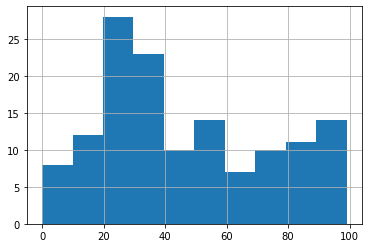

In [116]:
df[df.partial_ratio<100].partial_ratio.hist()

In [107]:
df.head(20) #most likely wrong answers

,context,question,text,prediction_text,partial_ratio
725,เฮอโรโดทัส (herodotos หรือ herodotus – ประมาณ พ.ศ. 58-118) นักประวัติศาสตร์ชาวกรีกผู้บันทึกสงครามเปอร์เซีย ผู้เริ่มต้นประวัติศาสตร์นิพนธ์ตะวันตก เกิดที่เมืองฮาลิคาร์นาสซัส ภาคตะวันตกเฉียงใต้ของเอเชียไมเนอร์ซึ่งในขณะนั้นอยู่ภายใต้การปกครองของเปอร์เซีย เฮอโรโดทัสได้เดินทางท่องเที่ยวศึกษาทั่วดินแดนในเอเชียไมเนอร์และตะวันออกกลาง และยังได้เดินทางลงใต้ไปอียิปต์ถึงเมืองเอเลแฟนทีน (อัสวานในปัจจุบัน)\n\n\nแผนที่โบราณแสดงส่วนของโลกที่มีมนุษย์อยู่อาศัย (oikumene) ประมาณ พ.ศ. 90 หรือ 450 ปีก่อนคริสตกาล โดยจำลองจากบันทึกของเฮอโรโดทัส\nเฮอโรโดทัส เคยอาศัยอยู่ที่กรุงเอเธนส์ หรืออย่างน้อยก็ตอนกลางของกรีกและได้พบกับโสโฟเคิลส์ (sophocles) ก่อนที่จะไปเข้าเป็นพลเมืองร่วมอยู่กับอาณานิคมกรีกที่เมืองธุริ (thurii) เมื่อปี พ.ศ. 100 และจากเมืองอาณานิคมธูรินี้เฮอโรโดทัสก็ได้เดินทางไปซิชิลีและอิตาลีตอนล่าง จากนั้นไปถึงลิเบีย ซีเรีย บาบิโลเนีย เมืองซูซาในอีแลม ลีเดีย ไพรเจียจนถึงบิแซนเทียม (byzantium) และมาซิโดเนีย โดยเดินทางทั้งทางบกและทางเรือ ทางภาคเหนือเฮอโรโดทัสได้ไปถึงแม่น้ำดานูบและไซเธียไปจนถึงทะเลดำ ซึ่งคงใช้เวลาเดินนานหลายปี ในระหว่างการเดินทางเขาได้รวบรวมข้อมูลต่าง ๆ ที่ได้พบเห็นไว้เป็นจำนวนมากและได้นำมาใช้ในการพรรณาทางประวัติศาสตร์ที่ถือว่ายิ่งใหญ่ โดยได้บันทึกสงครามระหว่างกรีกกับเปอร์เซีย และยังเป็นผู้จัดลำดับเจ็ดสิ่งมหัศจรรย์ของโลกขึ้นเป็นครั้งแรกซึ่งยังเป็นที่อ้างอิงกล่าวขานมาจนถึงปัจจุบัน ซิเซโรขนานนามเฮอโรโดทัสว่าเป็น “บิดาแห่งประวัติศาสตร์”,เฮอรอโดทัสเกิดเมื่อใด,พ.ศ. 58,ที่เมืองฮาลิคาร์นาสซัส,0
370,พระพุทธมณีรัตนปฏิมากร เป็นพระพุทธรูปที่สร้างขึ้นในรัชสมัยพระบาทสมเด็จพระมงกุฏเกล้าเจ้าอยู่หัวทรงพระกรุณาโปรดเกล้าให้สร้างขึ้นเพื่อเป็นพระแก้วประจำรัชกาลของพระองค์ เป็นพระหยกสีเขียวเข้ม ศิลปะแบบรัตนโกสินทร์ สร้างเมื่อพุทธศักราช 2457 หน้าตักกว้างประมาณ 9.5 นิ้วไม่ปรากฏเอกสารหรือหลักฐานว่าใช้พระพุทธมณีรัตนปฏิมากรในวาระโอกาสใดในอดีต ทั้งนี้เมื่อวันที่ 27 กรกฎาคม พ.ศ. 2560 สมเด็จพระเจ้าอยู่หัวมหาวชิราลงกรณ บดินทรเทพยวรางกูร ทรงพระกรุณาโปรดเกล้าฯ ให้อัญเชิญพระพุทธมณีรัตนปฏิมากร จากพระที่นั่งอัมพรสถาน พระราชวังดุสิต ไปในพิธีเจริญพระพุทธมนต์ถวายพระราชกุศลอุทิศถวาย พระบาทสมเด็จพระเจ้าอยู่หัวภูมิพลอดุลยเดช และพิธีเจริญพระพุทธมนต์ถวายพระพรชัยมงคลถวายพระราชกุศลสมเด็จพระนางเจ้าสิริกิติ์ พระบรมราชินีนาถ ในรัชกาลที่ 9 เนื่องในโอกาสวันเฉลิมพระชนมพรรษาสมเด็จพระเจ้าอยู่หัวฯ 28 กรกฎาคม พ.ศ. 2560 ณ พระลานพระราชวังดุสิ,พระพุทธมณีรัตนปฏิมากร สร้างเมื่อรัชสมัยใด,รัชสมัยพระบาทสมเด็จพระมงกุฏเกล้าเจ้าอยู่หัว,2457,0
61,"เบอร์เซิร์ก (ญี่ปุ่น: ベルセルク โรมาจิ: beruseruku; อังกฤษ: berserk) เป็นชื่อมังงะ แนวดาร์ค แฟนตาซี ของญี่ปุ่น วาดโดยเคนทาโร่ มิอุระ มีการดำเนินเรื่องเกิดขึ้นในยุคกลางของยุโรป โดยได้รับอิทธิพลมาจากโลกแห่งจินตนิมิตด้านมืด มีตัวละครเอกของเรื่องคือ กัทส์ ทหารรับจ้างผู้โดดเดี่ยวและ กริฟฟิท หัวหน้าของกลุ่มทหารรับจ้างที่รวมตัวกันภายใต้ชื่อ กองพันเหยี่ยว\n\nเนื้อเรื่องมีสาระสำคัญเกี่ยวกับความโดดเดี่ยวของมนุษย์ , ความสัมพันธ์ในเชิงของมิตรภาพ และเต็มไปด้วยการตั้งคำถามเกี่ยวกับมนุษยธรรม รวมถึงประเด็นเรื่องปีศาจและการต่อต้านพระเจ้า นอกจากนี้ยังสื่อให้เห็นถึงธรรมชาติของความเป็นมนุษย์ทั้งในด้านที่ดีที่สุดและเลวร้ายที่สุด\n\nเบอร์เซิร์กได้ชื่อว่าเป็นหนังสือการ์ตูนญี่ปุ่นที่เนื้อหาและภาพมีความรุนแรงสูง รวมถึงมีลายเส้นของภาพที่มีความละเอียดเป็นอย่างมาก ในขณะเดียวกันก็ได้รับความนิยมและมียอดขายมากอันดับต้นๆเช่นกัน ในประเทศญี่ปุ่นลงตีพิมพ์ในนิตยสารยัง แอนิมอล โดยสำนักพิมพ์ฮะคุเซนชะ ส่วนในประเทศไทยมีการตีพิมพ์ฉบับลิขสิทธิ์จัดจำหน่ายครั้งแรกโดยสำนักพิมพ์วิบูลย์กิจ ซึ่งได้ตีพิมพ์จนถึงฉบับรวมเล่มที่ 37 ต่อมาในปี พ.ศ. 2560 ทางสำนักพิมพ์วิบูลย์กิจได้ประกาศหยุดตีพิมพ์หนังสือในเครือฮะคุเซนชะ ทำให้บริษัทสยามอินเตอร์มัลติมีเดีย ได้เข้าถือครองลิขสิทธิ์การตีพิมพ์เรื่องเบอร์เซิร์กฉบับภาษาไทยในปัจจุบัน โดยมีการตีพิมพ์ซ้ำตั้งแต่เล่ม 1 - 37 และ เล่มที่ 38 เป็นต้นไป ส่วนฉบับอนิเมะได้ลิขสิทธิ์จัดจำหน่ายโดย tiga\n\nนอกจากนี้ยังมีการแปลและตีพิมพ์จัดจำหน่ายในอีกหลายประเทศเช่นสหราชอาณาจักร, ฝรั่งเศส, สเปน, เนเธอร์แลนด์, โปแลนด์, อิตาลี, เยอรมัน, บราซิล, เม็กซิโก และเกาหลีใต้",ฉบับอนิเมะได้ลิขสิทธิ์จัดจำหน่ายโดยค่ายอะไร,tiga,สำนักพิมพ์วิบูลย์กิจ,0
680,"ออสเตรเลียเน็กซ์ท็อปโมเดล ฤดูกาลที่ 9 เป็นรายการเรียลลิตี้โชว์ค้นหาสุดยอดนางแบบของประเทศออสเตร